# Load packages

In [1]:
import pymc3 as pm
import numpy as np
import math as m
import matplotlib.pyplot as plt
import dive 
import deerlab as dl
import warnings
from scipy.io import loadmat
import arviz as az

def preprocess(file_name):
    t, V = dl.deerload(file_name)
    V = dl.correctphase(V)
    t = dl.correctzerotime(V, t)
    
    return V, t

# Sample 1 analysis

## Load data

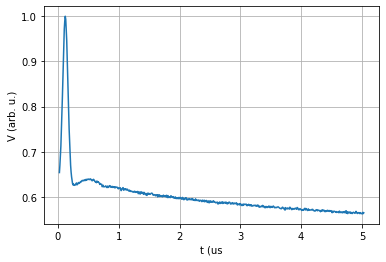

In [2]:
[V1_, t1_] = preprocess('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/ringtest_labB/sample1_labB.DSC')

# Cut off first point
t1=t1_[3:]
V1exp=V1_[3:]
t1 = t1+0.12
#t1 = t1+(3*0.008)

# Cut off 2+1 artifact
cut = 0.8
V1exp = V1exp[t1<=max(t1)-cut]
t1 = t1[t1<=max(t1)-cut]

# Normalize
V1exp = V1exp/np.max(V1exp)

# Plot
plt.plot(t1,V1exp)
plt.xlabel('t (us')
plt.ylabel('V (arb. u.)')
plt.grid()

## Build model

In [12]:
# Experimental parameters
tau1 = 0.4      # First inter-pulse delay, μs
tau2 = 6.0      # Second inter-pulse delay, μs
deadtime = 0.28  # Acquisition deadtime, μs
t1 = t1 + deadtime             # Account for deadtime

# Distance vector
r1 = np.arange(1.5,7.5,0.05) # nm

# Construct the model
V1model = dl.dipolarmodel(t1, r1, experiment = dl.ex_4pdeer(tau1,tau2, pathways=[1]))
compactness = dl.dipolarpenalty(Pmodel=None, r=r1, type='compactness')

## Initial Fit

In [19]:
# Fit the model to the data
results_s1 = dl.fit(V1model,V1exp,penalties=compactness)

# Print results summary
print(results_s1)

Goodness-of-fit: 
========= ============= ============ ======= =========== 
 Dataset   Noise level   Reduced 𝛘2   RMSD       AIC     
========= ============= ============ ======= =========== 
   #1         0.001        2.449      0.002   -3589.966  
========= ============= ============ ======= =========== 
Model hyperparameters: 
========================== =================== 
 Regularization parameter   Penalty weight #1  
========================== =================== 
          0.056                   0.001        
========================== =================== 
Model parameters: 
=========== =================== ========================= ====== ====================================== 
 Parameter   Value               95%-Confidence interval   Unit   Description                           
=========== =================== ========================= ====== ====================================== 
 mod         0.375               (0.373,0.377)                    Modulation depth            

## Plot

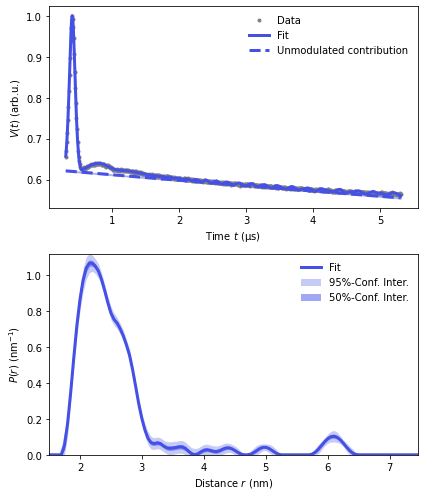

In [20]:
# Extract fitted dipolar signal
Vfit = results_s1.model
Vci = results_s1.modelUncert.ci(95)

# Extract fitted distance distribution
Pfit = results_s1.P
Pci95 = results_s1.PUncert.ci(95)
Pci50 = results_s1.PUncert.ci(50)

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: results_s1.P_scale*(1-mod)*dl.bg_hom3d(t1,conc,mod)
Bfit = Bfcn(results_s1.mod,results_s1.conc)
Bci = results_s1.propagate(Bfcn).ci(95)

plt.figure(figsize=[6,7])
violet = '#4550e6'
plt.subplot(211)
# Plot experimental and fitted data
plt.plot(t1,V1exp,'.',color='grey',label='Data')
plt.plot(t1,Vfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(t1,Vci[:,0],Vci[:,1],color=violet,alpha=0.3)
plt.plot(t1,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
plt.fill_between(t1,Bci[:,0],Bci[:,1],color=violet,alpha=0.3)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')
# Plot the distance distribution
plt.subplot(212)
plt.plot(r1,Pfit,color=violet,linewidth=3,label='Fit')
plt.fill_between(r1,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r1,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()

## Bootstrap uncertainty analysis 

## Parallelized vs not testing

### Run parallel

In [21]:
def bootfcn(Vexp):
    fit_s1 = dl.fit(V1model,V1exp,penalties=compactness)
    return fit_s1.model, fit_s1.P, [fit_s1.P_scale], [fit_s1.conc], [fit_s1.mod],[fit_s1.regparam]

V1fit=results_s1.model
s1_test_ANF_P= dl.bootstrap_analysis(bootfcn, V1exp, V1fit, samples=50,verbose=True,cores=-1)
dl.store_pickle(s1_test_ANF_P,'s1_test_ANF_P_50BS.pkl')

Bootstrap analysis with -1 cores:


100%|██████████| 50/50 [24:48<00:00, 29.77s/it]  


### Run not parallel

In [28]:
s1_test_ANF_NP = dl.fit(V1model,V1exp,penalties=compactness,bootstrap=50)
dl.store_pickle(s1_test_ANF_NP,'s1_test_ANF_NP_50BS.pkl')

KeyboardInterrupt: 

### Load data

In [5]:
s1_fit_50bs_ANF_P=dl.read_pickle('/Users/sarahsweger/Documents/GitHub/dive-scripts/manuscript/SRS_analysis/s1_test_ANF_P_50BS.pkl')
s1_fit_50bs_ANF_NP=dl.read_pickle('/Users/sarahsweger/Documents/GitHub/dive-scripts/manuscript/SRS_analysis/s1_test_50bs_ANF_NP_hyak.pkl')

### Parallel plots

(0.0, 1.1741825309002607)

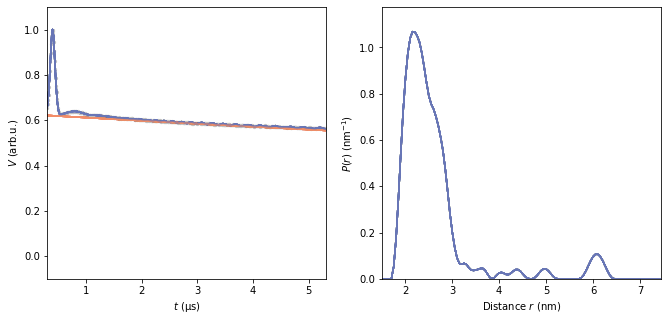

In [31]:
# Random samples from bootstrapping
#import random

# Variables from bootstrapping
V_BS = s1_fit_50bs_ANF_P[0]
P_BS = s1_fit_50bs_ANF_P[1]
mods_BS = s1_fit_50bs_ANF_P[4]
concs_BS=s1_fit_50bs_ANF_P[3]
regparam_BS=s1_fit_50bs_ANF_P[5]

#nDraws=100
#idxSamples = random.sample(range(V_BS.samples.shape[0]), nDraws)


# Extract fitted dipolar signal
Vfit = V_BS.mean
Vs = V_BS.samples#[idxSamples]

# Extract fitted distance distribution
Pfit = P_BS.mean
Ps = P_BS.samples#[idxSamples]

# Extract the unmodulated contribution
P_scale = s1_fit_50bs_ANF_P[2].mean
Bfcn = lambda mod,conc: P_scale*(1-mod)*dl.bg_hom3d(t1,conc,mod)
mods=mods_BS.samples#[idxSamples]
concs=concs_BS.samples#[idxSamples]
Bfit = Bfcn(mods_BS.mean,concs_BS.mean)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs.append(Bfcn(mod,conc))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(11)
orange = '#F38D68'

# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    ax1.plot(t1,V,color='#6876B6',alpha=0.2)
    ax1.plot(t1,B,color=orange,alpha=0.2)
ax1.scatter(t1, V1exp, color='#BFBFBF', s=5)
#ax1.plot(t1,Vfit,color=violet,label='Fit')
#ax1.plot(t1,Bfit,'--',color=orange,label='Unmodulated contribution')
ax1.set_xlabel('$t$ (µs)')
ax1.set_ylabel('$V$ (arb.u.)')
ax1.set_xlim((min(t1), max(t1)))
ax1.set_ylim(-0.1,1.1)

# Plot the distance distribution
for P in Ps:
    ax2.plot(r1,P,color='#6876B6',alpha=0.2)
#ax2.plot(r1,Pfit,color=violet,label='Fit')
ax2.set_xlabel('Distance $r$ (nm)')
ax2.set_ylabel('$P(r)$ (nm$^{-1}$)')
Pmax = max([max(P) for P in Ps])
ax2.set_xlim(min(r1), max(r1))
ax2.set_ylim(0, Pmax*1.1)

(array([50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.05625159, 0.05625657, 0.05626155, 0.05626653, 0.05627152,
        0.0562765 , 0.05628148, 0.05628646, 0.05629144, 0.05629642,
        0.0563014 ]),
 <BarContainer object of 10 artists>)

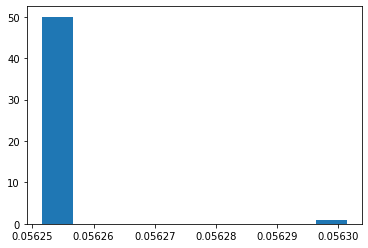

In [32]:
alpha_samples=regparam_BS.samples
plt.hist(alpha_samples)

### Not parallel plots

(0.0, 1.2610804021814432)

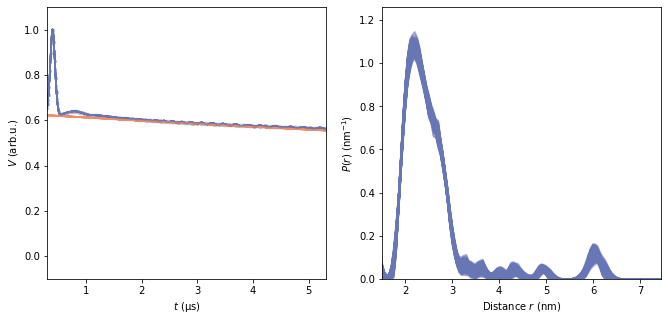

In [6]:
# Random samples from bootstrapping
#import random
#nDraws=100
#idxSamples = random.sample(range(s1_fit_50bs_ANF_NP.PUncert.samples.shape[0]), nDraws)

# Extract fitted dipolar signal
Vfit = s1_fit_50bs_ANF_NP.model
Vs = s1_fit_50bs_ANF_NP.modelUncert.samples#[idxSamples]

# Extract fitted distance distribution
Pfit = s1_fit_50bs_ANF_NP.P
Ps = s1_fit_50bs_ANF_NP.PUncert.samples#[idxSamples]

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: s1_fit_50bs_ANF_NP.P_scale*(1-mod)*dl.bg_hom3d(t1,conc,mod)
mods=s1_fit_50bs_ANF_NP.modUncert.samples#[idxSamples]
concs=s1_fit_50bs_ANF_NP.concUncert.samples#[idxSamples]
Bfit = Bfcn(s1_fit_50bs_ANF_NP.mod,s1_fit_50bs_ANF_NP.conc)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs.append(Bfcn(mod,conc))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(11)
orange = '#F38D68'

# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    ax1.plot(t1,V,color='#6876B6',alpha=0.2)
    ax1.plot(t1,B,color=orange,alpha=0.2)
ax1.scatter(t1, V1exp, color='#BFBFBF', s=5)
#ax1.plot(t1,Vfit,color=violet,label='Fit')
#ax1.plot(t1,Bfit,'--',color=orange,label='Unmodulated contribution')
ax1.set_xlabel('$t$ (µs)')
ax1.set_ylabel('$V$ (arb.u.)')
ax1.set_xlim((min(t1), max(t1)))
ax1.set_ylim(-0.1,1.1)

# Plot the distance distribution
for P in Ps:
    ax2.plot(r1,P,color='#6876B6',alpha=0.2)
#ax2.plot(r1,Pfit,color=violet,label='Fit')
ax2.set_xlabel('Distance $r$ (nm)')
ax2.set_ylabel('$P(r)$ (nm$^{-1}$)')
Pmax = max([max(P) for P in Ps])
ax2.set_xlim(min(r1), max(r1))
ax2.set_ylim(0, Pmax*1.1)

In [7]:
alpha = s1_fit_50bs_ANF_NP.regparamUncert.samples

AttributeError: 'numpy.float64' object has no attribute 'samples'

(array([[51.,  0.,  0., ...,  0.,  0.,  0.],
        [51.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 51.],
        ...,
        [51.,  0.,  0., ...,  0.,  0.,  0.],
        [51.,  0.,  0., ...,  0.,  0.,  0.],
        [51.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([4.77524513e-15, 6.25503682e+00, 1.25100736e+01, 1.87651105e+01,
        2.50201473e+01, 3.12751841e+01, 3.75302209e+01, 4.37852577e+01,
        5.00402945e+01, 5.62953314e+01, 6.25503682e+01]),
 <a list of 124 BarContainer objects>)

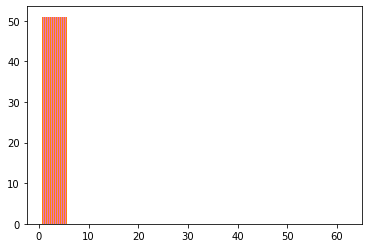

In [38]:
alpha_samples=s1_fit_50bs_ANF_NP.
plt.hist(alpha_samples)

In [6]:
s1_fit_1000bs_AF_P=dl.read_pickle('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/Figure6/fit_s1_DL_BS_1000_alphafix_parallel.pkl')
s1_fit_1000bs_AF_NP=dl.read_pickle('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/Figure6/s1_fit_1000bs_alphafixed_notparallel.pkl')
s1_fit_1000bs_ANF_P=dl.read_pickle('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/Figure6/s1_fit_1000bs_alphanotfixed_parallel.pkl')

### Spaghetti plots

#### Not parallelized code

ValueError: x and y must have same first dimension, but have shapes (627,) and (579,)

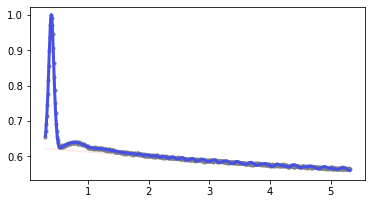

In [110]:
# Random samples from bootstrapping
import random
nDraws=100
idxSamples = random.sample(range(s1_fit_1000bs_alphafix.PUncert.samples.shape[0]), nDraws)

# Extract fitted dipolar signal
Vfit = s1_fit_1000bs_alphafix.model
Vci = s1_fit_1000bs_alphafix.modelUncert.ci(95)
#Vs = s1_fit_1000bs_alphafix.modelUncert.samples#[idxSamples]

# Extract fitted distance distribution
Pfit = s1_fit_1000bs_alphafix.P
#Pci95 = s1_fit_1000bs.PUncert.ci(95)
#Pci50 = s1_fit_1000bs.PUncert.ci(50)
#Ps = s1_fit_1000bs_alphafix.PUncert.samples#[idxSamples]

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: s1_fit_1000bs_alphafix.P_scale*(1-mod)*dl.bg_hom3d(t1,conc,mod)
mods=s1_fit_1000bs_alphafix.modUncert.samples#[idxSamples]
concs=s1_fit_1000bs_alphafix.concUncert.samples#[idxSamples]
#Bfit = Bfcn(s1_fit_1000bs_alphafix.mod,s1_fit_1000bs_alphafix.conc)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs_ = Bfcn(mod,conc)
Bs.append(Bs_)

plt.figure(figsize=[6,7])
violet = '#4550e6'
orange = "#F38D68"
plt.subplot(211)
# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    plt.plot(t1,V,color=violet,alpha=0.2)
    plt.plot(t1,B,color=orange,alpha=0.2)
plt.plot(t1,V1exp,'.',color='grey',label='Data')
plt.plot(t1,Vfit,linewidth=3,color=violet,label='Fit')
plt.plot(t1,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')
# Plot the distance distribution
plt.subplot(212)
for P in Ps:
    plt.plot(r1,P,color=violet,alpha=0.2)
plt.plot(r1,Pfit,color=violet,linewidth=3,label='Fit')
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()

In [111]:
print(Vci)

[[0.6569897  0.65872377]
 [0.67238006 0.67411178]
 [0.69167149 0.69345928]
 ...
 [0.56016851 0.5614897 ]
 [0.55963081 0.56098114]
 [0.55924283 0.56062341]]


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7., 92.]),
 array([33.48859302, 36.30153086, 39.1144687 , 41.92740654, 44.74034437,
        47.55328221, 50.36622005, 53.17915789, 55.99209572, 58.80503356,
        61.6179714 ]),
 <BarContainer object of 10 artists>)

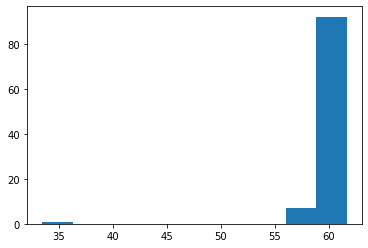

In [63]:
concs_full=s1_fit_1000bs_alphafix.concUncert.samples
plt.hist(concs)

#### alpha fixed, not parallel

(0.0, 1.220529692571758)

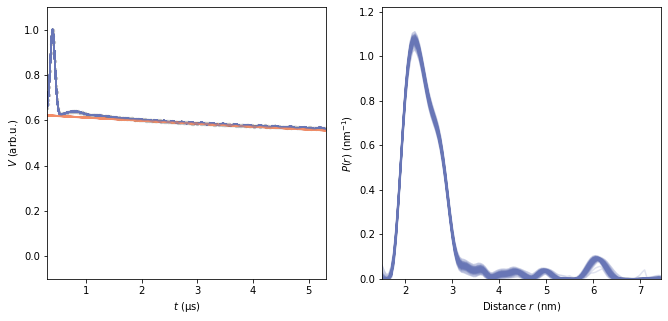

In [7]:
# Random samples from bootstrapping
import random
nDraws=100
idxSamples = random.sample(range(s1_fit_1000bs_AF_NP.PUncert.samples.shape[0]), nDraws)

# Extract fitted dipolar signal
Vfit = s1_fit_1000bs_AF_NP.model
Vs = s1_fit_1000bs_AF_NP.modelUncert.samples[idxSamples]

# Extract fitted distance distribution
Pfit = s1_fit_1000bs_AF_NP.P
Ps = s1_fit_1000bs_AF_NP.PUncert.samples[idxSamples]

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: s1_fit_1000bs_AF_NP.P_scale*(1-mod)*dl.bg_hom3d(t1,conc,mod)
mods=s1_fit_1000bs_AF_NP.modUncert.samples[idxSamples]
concs=s1_fit_1000bs_AF_NP.concUncert.samples[idxSamples]
Bfit = Bfcn(s1_fit_1000bs_AF_NP.mod,s1_fit_1000bs_AF_NP.conc)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs.append(Bfcn(mod,conc))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(11)
orange = '#F38D68'

# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    ax1.plot(t1,V,color='#6876B6',alpha=0.2)
    ax1.plot(t1,B,color=orange,alpha=0.2)
ax1.scatter(t1, V1exp, color='#BFBFBF', s=5)
#ax1.plot(t1,Vfit,color=violet,label='Fit')
#ax1.plot(t1,Bfit,'--',color=orange,label='Unmodulated contribution')
ax1.set_xlabel('$t$ (µs)')
ax1.set_ylabel('$V$ (arb.u.)')
ax1.set_xlim((min(t1), max(t1)))
ax1.set_ylim(-0.1,1.1)

# Plot the distance distribution
for P in Ps:
    ax2.plot(r1,P,color='#6876B6',alpha=0.2)
#ax2.plot(r1,Pfit,color=violet,label='Fit')
ax2.set_xlabel('Distance $r$ (nm)')
ax2.set_ylabel('$P(r)$ (nm$^{-1}$)')
Pmax = max([max(P) for P in Ps])
ax2.set_xlim(min(r1), max(r1))
ax2.set_ylim(0, Pmax*1.1)

(array([797., 197.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   5.]),
 array([0.37391062, 0.37587929, 0.37784796, 0.37981663, 0.3817853 ,
        0.38375397, 0.38572264, 0.38769131, 0.38965998, 0.39162865,
        0.39359732]),
 <BarContainer object of 10 artists>)

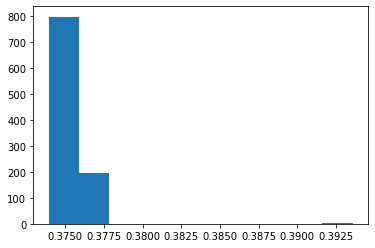

In [12]:
full_mods_NP=mods=s1_fit_1000bs_AF_NP.modUncert.samples
plt.hist(full_mods_NP)

### alpha fixed, parallel

In [10]:
# Random samples from bootstrapping
import random

# Variables from bootstrapping
V_BS = s1_fit_1000bs_AF_P[0]
P_BS = s1_fit_1000bs_AF_P[1]
mods_BS = s1_fit_1000bs_AF_P[4]
concs_BS=s1_fit_1000bs_AF_P[2]
regparam_BS=s1_fit_1000bs_AF_P[5]

nDraws=100
idxSamples = random.sample(range(V_BS.samples.shape[0]), nDraws)


# Extract fitted dipolar signal
Vfit = V_BS.mean
Vs = V_BS.samples[idxSamples]

# Extract fitted distance distribution
Pfit = P_BS.mean
Ps = P_BS.samples[idxSamples]

# Extract the unmodulated contribution
P_scale = s1_fit_1000bs_AF_P[3].mean
Bfcn = lambda mod,conc: P_scale*(1-mod)*dl.bg_hom3d(t1,conc,mod)
mods=mods_BS.samples[idxSamples]
concs=concs_BS.samples[idxSamples]
Bfit = Bfcn(mods_BS.mean,concs_BS.mean)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs.append(Bfcn(mod,conc))

(0.0, 1.1740724665008746)

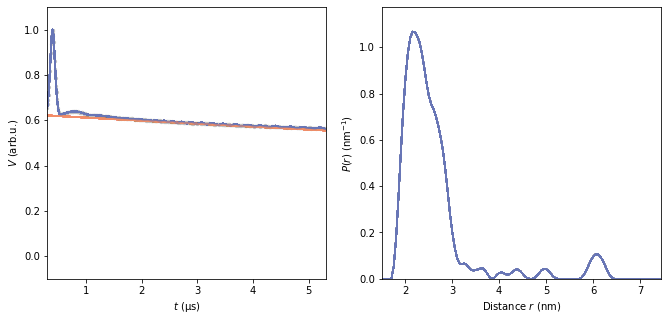

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(11)
orange = '#F38D68'

# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    ax1.plot(t1,V,color='#6876B6',alpha=0.2)
    ax1.plot(t1,B,color=orange,alpha=0.2)
ax1.scatter(t1, V1exp, color='#BFBFBF', s=5)
#ax1.plot(t1,Vfit,color=violet,label='Fit')
#ax1.plot(t1,Bfit,'--',color=orange,label='Unmodulated contribution')
ax1.set_xlabel('$t$ (µs)')
ax1.set_ylabel('$V$ (arb.u.)')
ax1.set_xlim((min(t1), max(t1)))
ax1.set_ylim(-0.1,1.1)

# Plot the distance distribution
for P in Ps:
    ax2.plot(r1,P,color='#6876B6',alpha=0.2)
#ax2.plot(r1,Pfit,color=violet,label='Fit')
ax2.set_xlabel('Distance $r$ (nm)')
ax2.set_ylabel('$P(r)$ (nm$^{-1}$)')
Pmax = max([max(P) for P in Ps])
ax2.set_xlim(min(r1), max(r1))
ax2.set_ylim(0, Pmax*1.1)

(array([999.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([0.3749769 , 0.37497888, 0.37498085, 0.37498283, 0.37498481,
        0.37498679, 0.37498877, 0.37499075, 0.37499272, 0.3749947 ,
        0.37499668]),
 <BarContainer object of 10 artists>)

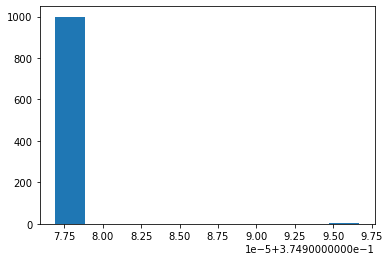

In [15]:
full_mods_P = s1_fit_1000bs_AF_P[4].samples
plt.hist(full_mods_P)

(0.0, 1.1741059326002463)

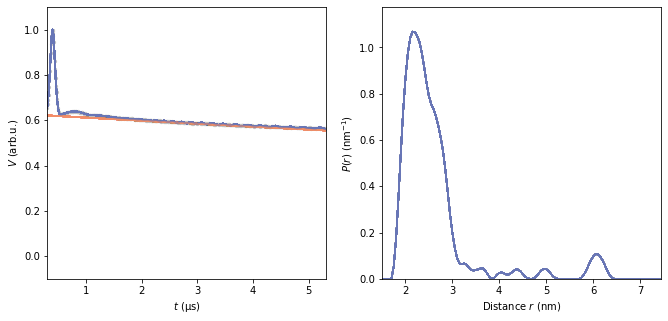

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(11)
orange = '#F38D68'

# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    ax1.plot(t1,V,color='#6876B6',alpha=0.2)
    ax1.plot(t1,B,color=orange,alpha=0.2)
ax1.scatter(t1, V1exp, color='#BFBFBF', s=5)
#ax1.plot(t1,Vfit,color=violet,label='Fit')
#ax1.plot(t1,Bfit,'--',color=orange,label='Unmodulated contribution')
ax1.set_xlabel('$t$ (µs)')
ax1.set_ylabel('$V$ (arb.u.)')
ax1.set_xlim((min(t1), max(t1)))
ax1.set_ylim(-0.1,1.1)

# Plot the distance distribution
for P in Ps:
    ax2.plot(r1,P,color='#6876B6',alpha=0.2)
#ax2.plot(r1,Pfit,color=violet,label='Fit')
ax2.set_xlabel('Distance $r$ (nm)')
ax2.set_ylabel('$P(r)$ (nm$^{-1}$)')
Pmax = max([max(P) for P in Ps])
ax2.set_xlim(min(r1), max(r1))
ax2.set_ylim(0, Pmax*1.1)

#fig = plt.gcf()
#fig.savefig("s1_DL_BS.svg")

### alpha posterior

In [83]:
alpha_samples = s1_fit_1000bs[5].samples
mod_samples = s1_fit_1000bs[4].samples

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1000.]),
 array([0.37490084, 0.37490713, 0.37491342, 0.37491971, 0.374926  ,
        0.37493229, 0.37493858, 0.37494486, 0.37495115, 0.37495744,
        0.37496373]),
 <BarContainer object of 10 artists>)

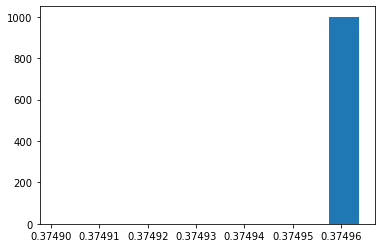

In [84]:
plt.hist(mod_samples)

## Confidence intervals

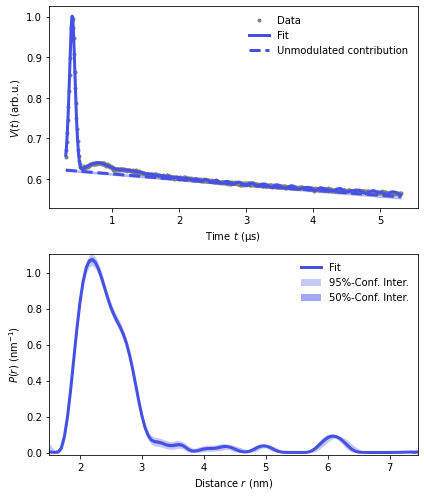

In [93]:
# Extract fitted dipolar signal
Vfit = s1_fit_1000bs_alphafix.model
Vci = s1_fit_1000bs_alphafix.modelUncert.ci(95)

# Extract fitted distance distribution
Pfit = s1_fit_1000bs_alphafix.P
Pci95 = s1_fit_1000bs_alphafix.PUncert.ci(95)
Pci50 = s1_fit_1000bs_alphafix.PUncert.ci(50)

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: s1_fit_1000bs_alphafix.P_scale*(1-mod)*dl.bg_hom3d(t1,conc,mod)
Bfit = Bfcn(s1_fit_1000bs_alphafix.mod,s1_fit_1000bs_alphafix.conc)
Bci = s1_fit_1000bs_alphafix.propagate(Bfcn).ci(95)

plt.figure(figsize=[6,7])
violet = '#4550e6'
plt.subplot(211)
# Plot experimental and fitted data
plt.plot(t1,V1exp,'.',color='grey',label='Data')
plt.plot(t1,Vfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(t1,Vci[:,0],Vci[:,1],color=violet,alpha=0.3)
plt.plot(t1,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
plt.fill_between(t1,Bci[:,0],Bci[:,1],color=violet,alpha=0.3)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')
# Plot the distance distribution
plt.subplot(212)
plt.plot(r1,Pfit,color=violet,linewidth=3,label='Fit')
plt.fill_between(r1,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r1,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()

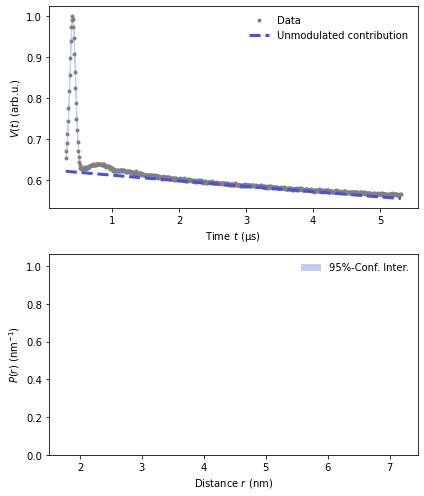

In [101]:
# Extract fitted dipolar signal
Vuq = s1_fit_1000bs[0]
Vfit = Vuq.mean
Vci = Vuq.ci(95)

# Extract fitted distance distribution
Pfit = s1_fit_1000bs[1].mean
Pci95 = s1_fit_1000bs[1].ci(95)
#Pci50 = s1_fit_1000bs[1].ci(50)

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: s1_fit_1000bs[2].mean*(1-mod)*dl.bg_hom3d(t1,conc,mod)
Bfit = Bfcn(s1_fit_1000bs[4].mean,s1_fit_1000bs[3].mean)
#Bci = Bfit.ci(95)

plt.figure(figsize=[6,7])
violet = '#4550e6'
plt.subplot(211)
# Plot experimental and fitted data
plt.plot(t1,V1exp,'.',color='grey',label='Data')
#plt.plot(t1,Vfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(t1,Vci[:,0],Vci[:,1],color=violet,alpha=0.3)
plt.plot(t1,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
#plt.fill_between(t1,Bci[:,0],Bci[:,1],color=violet,alpha=0.3)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')
# Plot the distance distribution
plt.subplot(212)
#lt.plot(r1,Pfit,color=violet,linewidth=3,label='Fit')
plt.fill_between(r1,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
#plt.fill_between(r1,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()

### Only fixing alpha

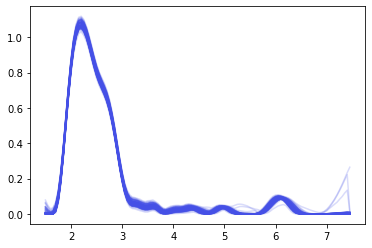

In [39]:
import random
nDraws=100
idxSamples = random.sample(range(s1_fit_1000bs.PUncert.samples.shape[0]), nDraws)
P_samp=s1_fit_1000bs.PUncert.samples[idxSamples]
violet = '#4550e6'
for P in P_samp:
    plt.plot(r1, P,color=violet,alpha=0.2)

## For paper

In [8]:
s1_fit_500bs_ANF_NP=dl.read_pickle('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/Figure6/s1_fit_500bs_alphafixed_notparallel.pkl')

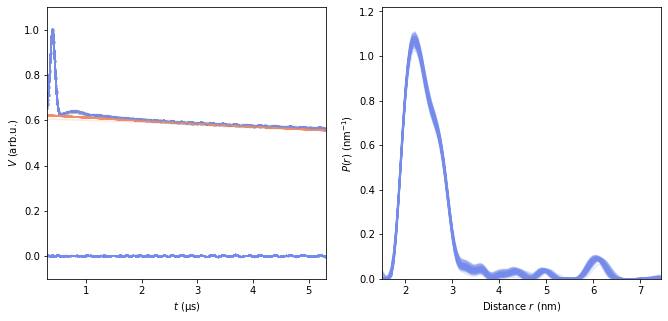

In [16]:
# Random samples from bootstrapping
import random
nDraws=100
idxSamples = random.sample(range(s1_fit_500bs_ANF_NP.modelUncert.samples.shape[0]), nDraws)

# Extract fitted dipolar signal
Vfit = s1_fit_500bs_ANF_NP.model
Vs = s1_fit_500bs_ANF_NP.modelUncert.samples[idxSamples]

# Extract fitted distance distribution
Pfit = s1_fit_500bs_ANF_NP.P
Ps = s1_fit_500bs_ANF_NP.PUncert.samples[idxSamples]

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: s1_fit_500bs_ANF_NP.P_scale*(1-mod)*dl.bg_hom3d(t1,conc,mod)
mods=s1_fit_500bs_ANF_NP.modUncert.samples[idxSamples]
concs=s1_fit_500bs_ANF_NP.concUncert.samples[idxSamples]
Bfit = Bfcn(s1_fit_500bs_ANF_NP.mod,s1_fit_500bs_ANF_NP.conc)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs.append(Bfcn(mod,conc))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(11)
orange = '#F38D68'

# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    residuals = V - V1exp
    ax1.plot(t1,V,color='#758BEC',alpha=0.2)
    ax1.plot(t1,B,color=orange,alpha=0.2)
    ax1.plot(t1, residuals, color='#758BEC', alpha=0.2)
ax1.scatter(t1, V1exp, color='#BFBFBF', s=5)
#ax1.plot(t1,Vfit,color=violet,label='Fit')
#ax1.plot(t1,Bfit,'--',color=orange,label='Unmodulated contribution')
ax1.set_xlabel('$t$ (µs)')
ax1.set_ylabel('$V$ (arb.u.)')
ax1.set_xlim((min(t1), max(t1)))
ax1.set_ylim(-0.1,1.1)

# Plot the distance distribution
for P in Ps:
    ax2.plot(r1,P,color='#758BEC',alpha=0.2)
#ax2.plot(r1,Pfit,color=violet,label='Fit')
ax2.set_xlabel('Distance $r$ (nm)')
ax2.set_ylabel('$P(r)$ (nm$^{-1}$)')
Pmax = max([max(P) for P in Ps])
ax2.set_xlim(min(r1), max(r1))
ax2.set_ylim(0, Pmax*1.1)
plt.gcf()
fig.savefig("s1_DL_BS_500s.svg")

In [26]:
print(np.log10(s1_fit_500bs_ANF_NP.regparam))

-1.2493670570515445


# Sample 2 analysis

## Load data

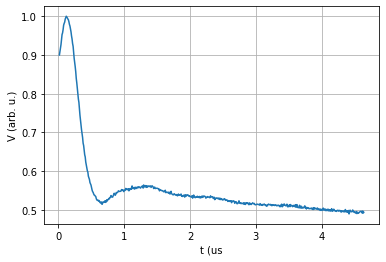

In [30]:
[V2_, t2_] = preprocess('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/ringtest_labB/sample2_labB.DSC')


# Cut off first point, shift zero time 
t2=t2_[1:]
V2exp=V2_[1:]
t2 = t2+0.008

# Cut off 2+1 artifact
cut = 1.2
V2exp = V2exp[t2<=max(t2)-cut]
t2 = t2[t2<=max(t2)-cut]

# Normalize
V2exp = V2exp/np.max(V2exp)

# Plot
plt.plot(t2,V2exp)
plt.xlabel('t (us')
plt.ylabel('V (arb. u.)')
plt.grid()

## Build model

In [31]:
# Experimental parameters
tau1 = 0.4      # First inter-pulse delay, μs
tau2 = 6.0      # Second inter-pulse delay, μs
deadtime = 0.28  # Acquisition deadtime, μs
t2 = t2 + deadtime             # Account for deadtime

# Distance vector
r2 = np.arange(1.5,7.5,0.05) # nm

# Construct the model
V2model = dl.dipolarmodel(t2, r2, experiment = dl.ex_4pdeer(tau1,tau2, pathways=[1]))
compactness = dl.dipolarpenalty(Pmodel=None, r=r2, type='compactness')

## Fit

In [135]:
# Fit the model to the data
results_s2 = dl.fit(V2model,V2exp,penalties=compactness)

# Print results summary
print(results_s2)

Goodness-of-fit: 
========= ============= ============ ======= =========== 
 Dataset   Noise level   Reduced 𝛘2   RMSD       AIC     
========= ============= ============ ======= =========== 
   #1         0.002        0.926      0.002   -3590.346  
========= ============= ============ ======= =========== 
Model hyperparameters: 
========================== =================== 
 Regularization parameter   Penalty weight #1  
========================== =================== 
          0.032                   0.017        
========================== =================== 
Model parameters: 
=========== ==================== ========================= ====== ====================================== 
 Parameter   Value                95%-Confidence interval   Unit   Description                           
=========== ==================== ========================= ====== ====================================== 
 mod         0.426                (0.424,0.427)                    Modulation depth        

## Plot

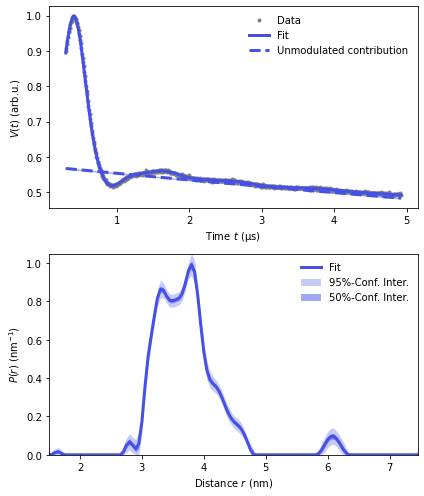

In [136]:
# Extract fitted dipolar signal
Vfit = results_s2.model
Vci = results_s2.modelUncert.ci(95)

# Extract fitted distance distribution
Pfit = results_s2.P
Pci95 = results_s2.PUncert.ci(95)
Pci50 = results_s2.PUncert.ci(50)

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: results_s2.P_scale*(1-mod)*dl.bg_hom3d(t2,conc,mod)
Bfit = Bfcn(results_s2.mod,results_s2.conc)
Bci = results_s2.propagate(Bfcn).ci(95)

plt.figure(figsize=[6,7])
violet = '#4550e6'
plt.subplot(211)
# Plot experimental and fitted data
plt.plot(t2,V2exp,'.',color='grey',label='Data')
plt.plot(t2,Vfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(t2,Vci[:,0],Vci[:,1],color=violet,alpha=0.3)
plt.plot(t2,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
plt.fill_between(t2,Bci[:,0],Bci[:,1],color=violet,alpha=0.3)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')
# Plot the distance distribution
plt.subplot(212)
plt.plot(r2,Pfit,color=violet,linewidth=3,label='Fit')
plt.fill_between(r2,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r2,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()

## Bootstrap analysis

In [76]:
s2_fit_1000bs_ANF_P=dl.read_pickle('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/Figure5/s2_fit_1000bs_alphanotfixed_parallel.pkl')
s2_fit_1000bs_AF_NP=dl.read_pickle('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/Figure5/s2_fit_1000bs_alphanotfixed_parallel.pkl')

(0.0, 2.272404818830168)

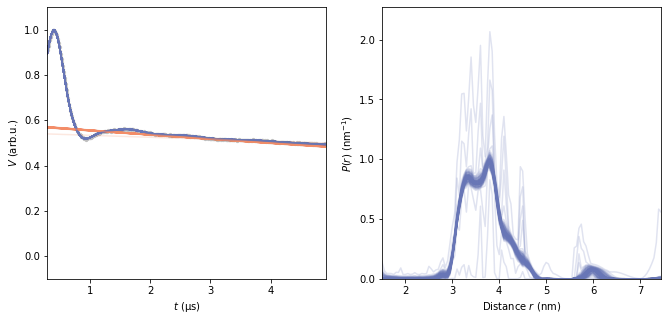

In [20]:
# Random samples from bootstrapping
import random
nDraws=100
idxSamples = random.sample(range(s2_fit_1000bs.PUncert.samples.shape[0]), nDraws)

# Extract fitted dipolar signal
Vfit = s2_fit_1000bs.model
Vs = s2_fit_1000bs.modelUncert.samples[idxSamples]

# Extract fitted distance distribution
Pfit = s2_fit_1000bs.P
Ps = s2_fit_1000bs.PUncert.samples[idxSamples]

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: s2_fit_1000bs.P_scale*(1-mod)*dl.bg_hom3d(t2,conc,mod)
mods=s2_fit_1000bs.modUncert.samples[idxSamples]
concs=s2_fit_1000bs.concUncert.samples[idxSamples]
Bfit = Bfcn(s2_fit_1000bs.mod,s2_fit_1000bs.conc)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs.append(Bfcn(mod,conc))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(11)
orange = '#F38D68'

# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    ax1.plot(t2,V,color='#6876B6',alpha=0.2)
    ax1.plot(t2,B,color=orange,alpha=0.2)
ax1.scatter(t2, V2exp, color='#BFBFBF', s=5)
#ax1.plot(t1,Vfit,color=violet,label='Fit')
#ax1.plot(t1,Bfit,'--',color=orange,label='Unmodulated contribution')
ax1.set_xlabel('$t$ (µs)')
ax1.set_ylabel('$V$ (arb.u.)')
ax1.set_xlim((min(t2), max(t2)))
ax1.set_ylim(-0.1,1.1)

# Plot the distance distribution
for P in Ps:
    ax2.plot(r2,P,color='#6876B6',alpha=0.2)
#ax2.plot(r1,Pfit,color=violet,label='Fit')
ax2.set_xlabel('Distance $r$ (nm)')
ax2.set_ylabel('$P(r)$ (nm$^{-1}$)')
Pmax = max([max(P) for P in Ps])
ax2.set_xlim(min(r2), max(r2))
ax2.set_ylim(0, Pmax*1.1)

In [102]:
# Random samples from bootstrapping
import random
nDraws=100
#idxSamples = random.sample(range(s2_fit_1000bs[0].samples.shape[0]), nDraws)
V_BS = s2_fit_1000bs[0]
P_BS = s2_fit_1000bs[1]
mods_BS = s2_fit_1000bs[3]
concs_BS=s2_fit_1000bs[4]
regparam_BS=s2_fit_1000bs[5]

# Extract fitted dipolar signal
Vfit = V_BS.mean
Vci = V_BS.ci(95)
#Vfit = results_s1.model
#Vs = V_BS.samples#[idxSamples]

# Extract fitted distance distribution
#Pfit = results_s1.P
Pfit = P_BS.mean
Ps = P_BS.samples#[idxSamples]

# Extract the unmodulated contribution
P_scale = s2_fit_1000bs[2].mean
Bfcn = lambda mod,conc: P_scale*(1-mod)*dl.bg_hom3d(t2,conc,mod)
mods=mods_BS.samples#[idxSamples]
concs=concs_BS.samples#[idxSamples]
Bfit = Bfcn(s2_fit_1000bs[3].mean,s2_fit_1000bs[4].mean)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs_ = Bfcn(mod,conc)
Bs.append(Bs_)

In [105]:
print(Vci)

[[0.89426515 0.89426522]
 [0.9067565  0.90675667]
 [0.91873447 0.91873472]
 ...
 [0.49285954 0.49286053]
 [0.49272312 0.49272416]
 [0.49258217 0.49258327]]


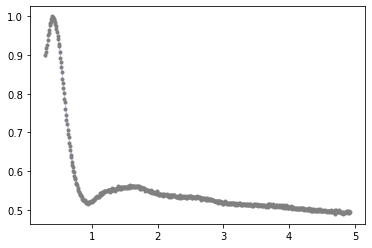

In [104]:
plt.plot(t2,V2exp,'.',color='grey',label='Data')
#plt.plot(t2,Vfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(t2,Vci[:,0],Vci[:,1],color=violet,alpha=0.3)

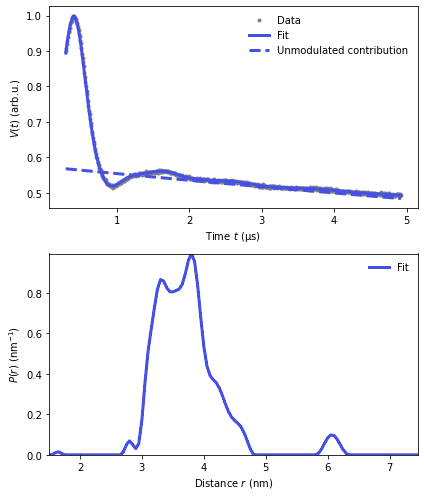

In [89]:
plt.figure(figsize=[6,7])
violet = '#4550e6'
orange = "#F38D68"
plt.subplot(211)
# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    plt.plot(t2,V,color=violet,alpha=0.2)
    plt.plot(t2,B,color=orange,alpha=0.2)
plt.plot(t2,V2exp,'.',color='grey',label='Data')
plt.plot(t2,Vfit,linewidth=3,color=violet,label='Fit')
plt.plot(t2,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')
# Plot the distance distribution
plt.subplot(212)
for P in Ps:
    plt.plot(r2,P,color=violet,alpha=0.2)
plt.plot(r2,Pfit,color=violet,linewidth=3,label='Fit')
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()

## For paper

In [32]:
s2_fit_500bs_ANF_NP=dl.read_pickle('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/Figure6/s2_fit_500bs_alphafixed_notparallel.pkl')

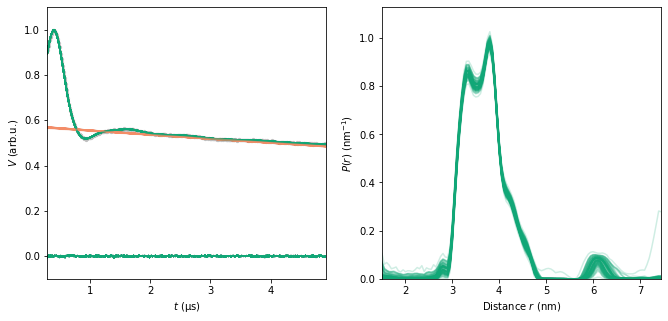

In [34]:
# Random samples from bootstrapping
import random
nDraws=100
idxSamples = random.sample(range(s2_fit_500bs_ANF_NP.modelUncert.samples.shape[0]), nDraws)

# Extract fitted dipolar signal
Vfit = s2_fit_500bs_ANF_NP.model
Vs = s2_fit_500bs_ANF_NP.modelUncert.samples[idxSamples]

# Extract fitted distance distribution
Pfit = s2_fit_500bs_ANF_NP.P
Ps = s2_fit_500bs_ANF_NP.PUncert.samples[idxSamples]

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: s2_fit_500bs_ANF_NP.P_scale*(1-mod)*dl.bg_hom3d(t2,conc,mod)
mods=s2_fit_500bs_ANF_NP.modUncert.samples[idxSamples]
concs=s2_fit_500bs_ANF_NP.concUncert.samples[idxSamples]
Bfit = Bfcn(s2_fit_500bs_ANF_NP.mod,s2_fit_500bs_ANF_NP.conc)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs.append(Bfcn(mod,conc))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(11)
orange = '#F38D68'

# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    residuals = V - V2exp
    ax1.plot(t2,V,color='#11A777',alpha=0.2)
    ax1.plot(t2,B,color=orange,alpha=0.2)
    ax1.plot(t2, residuals, color='#11A777', alpha=0.2)
ax1.scatter(t2, V2exp, color='#BFBFBF', s=5)
#ax1.plot(t1,Vfit,color=violet,label='Fit')
#ax1.plot(t1,Bfit,'--',color=orange,label='Unmodulated contribution')
ax1.set_xlabel('$t$ (µs)')
ax1.set_ylabel('$V$ (arb.u.)')
ax1.set_xlim((min(t2), max(t2)))
ax1.set_ylim(-0.1,1.1)

# Plot the distance distribution
for P in Ps:
    ax2.plot(r2,P,color='#11A777',alpha=0.2)
#ax2.plot(r1,Pfit,color=violet,label='Fit')
ax2.set_xlabel('Distance $r$ (nm)')
ax2.set_ylabel('$P(r)$ (nm$^{-1}$)')
Pmax = max([max(P) for P in Ps])
ax2.set_xlim(min(r2), max(r2))
ax2.set_ylim(0, Pmax*1.1)
plt.gcf()
fig.savefig("s2_DL_BS_500s.svg")

In [35]:
print(np.log10(s2_fit_500bs_ANF_NP.regparam))

-1.5037446514181307


# Sample 3 analysis

## Load data

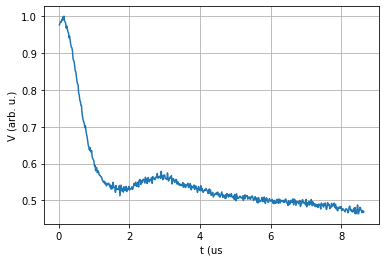

In [18]:
[V3_, t3_] = preprocess('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/ringtest_labB/sample3_labB.DSC')

# Cut off first point, shift zero time 
t3=t3_[1:]
V3exp=V3_[1:]
#t3 = t3-(0.12-0.008)
t3=t3+0.008

# Cut off 2+1 artifact
cut = 1.2
V3exp = V3exp[t3<=max(t3)-cut]
t3 = t3[t3<=max(t3)-cut]

# Normalize
V3exp = V3exp/np.max(V3exp)

# Plot
plt.plot(t3,V3exp)
plt.xlabel('t (us')
plt.ylabel('V (arb. u.)')
plt.grid()

## Build model

In [19]:
# Experimental parameters
tau1 = 0.4      # First inter-pulse delay, μs
tau2 = 10.0      # Second inter-pulse delay, μs
deadtime = 0.28  # Acquisition deadtime, μs
t3 = t3 + deadtime             # Account for deadtime

# Distance vector
r3 = np.arange(1.5,9.0,0.05) # nm

# Construct the model
V3model = dl.dipolarmodel(t3, r3, experiment = dl.ex_4pdeer(tau1,tau2, pathways=[1]))
compactness = dl.dipolarpenalty(Pmodel=None, r=r3, type='compactness')

## Fit

In [146]:
# Fit the model to the data
results_s3 = dl.fit(V3model,V3exp,penalties=compactness)

# Print results summary
print(results_s3)

Goodness-of-fit: 
========= ============= ============ ======= =========== 
 Dataset   Noise level   Reduced 𝛘2   RMSD       AIC     
========= ============= ============ ======= =========== 
   #1         0.005        0.946      0.005   -2293.237  
========= ============= ============ ======= =========== 
Model hyperparameters: 
========================== =================== 
 Regularization parameter   Penalty weight #1  
========================== =================== 
          0.385                   0.027        
========================== =================== 
Model parameters: 
=========== ==================== ========================= ====== ====================================== 
 Parameter   Value                95%-Confidence interval   Unit   Description                           
=========== ==================== ========================= ====== ====================================== 
 mod         0.401                (0.398,0.404)                    Modulation depth        

## Plot

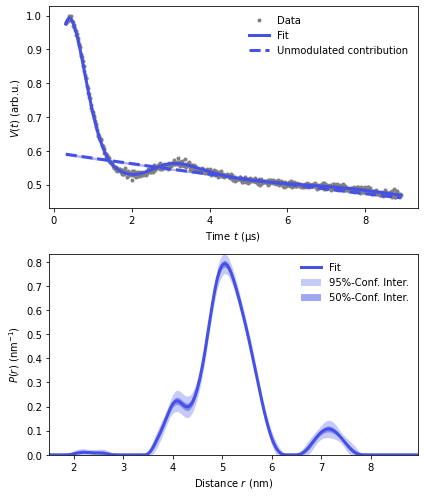

In [147]:
# Extract fitted dipolar signal
Vfit = results_s3.model
Vci = results_s3.modelUncert.ci(95)

# Extract fitted distance distribution
Pfit = results_s3.P
Pci95 = results_s3.PUncert.ci(95)
Pci50 = results_s3.PUncert.ci(50)

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: results_s3.P_scale*(1-mod)*dl.bg_hom3d(t3,conc,mod)
Bfit = Bfcn(results_s3.mod,results_s3.conc)
Bci = results_s3.propagate(Bfcn).ci(95)

plt.figure(figsize=[6,7])
violet = '#4550e6'
plt.subplot(211)
# Plot experimental and fitted data
plt.plot(t3,V3exp,'.',color='grey',label='Data')
plt.plot(t3,Vfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(t3,Vci[:,0],Vci[:,1],color=violet,alpha=0.3)
plt.plot(t3,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
plt.fill_between(t3,Bci[:,0],Bci[:,1],color=violet,alpha=0.3)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')
# Plot the distance distribution
plt.subplot(212)
plt.plot(r3,Pfit,color=violet,linewidth=3,label='Fit')
plt.fill_between(r3,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r3,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()

## Bootstrap analysis

In [148]:
s3_fit_1000bs_ANF_P=dl.read_pickle('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/Figure6/s3_fit_1000bs_alphanotfixed_parallel.pkl')
s3_fit_1000bs_AF_NP=dl.read_pickle('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/Figure6/s3_fit_1000bs_alphafixed_notparallel.pkl')

### Fixed alpha, not parallel

(0.0, 0.9111431524665874)

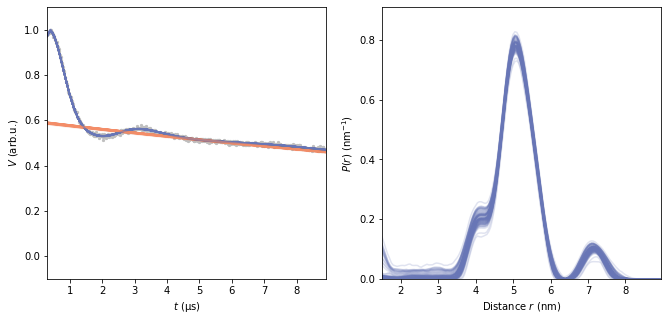

In [156]:
# Random samples from bootstrapping
import random
nDraws=100
idxSamples = random.sample(range(s3_fit_1000bs_AF_NP.PUncert.samples.shape[0]), nDraws)

# Extract fitted dipolar signal
Vfit = s3_fit_1000bs_AF_NP.model
Vs = s3_fit_1000bs_AF_NP.modelUncert.samples[idxSamples]

# Extract fitted distance distribution
Pfit = s3_fit_1000bs_AF_NP.P
Ps = s3_fit_1000bs_AF_NP.PUncert.samples[idxSamples]

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: s3_fit_1000bs_AF_NP.P_scale*(1-mod)*dl.bg_hom3d(t3,conc,mod)
mods=s3_fit_1000bs_AF_NP.modUncert.samples[idxSamples]
concs=s3_fit_1000bs_AF_NP.concUncert.samples[idxSamples]
Bfit = Bfcn(s3_fit_1000bs_AF_NP.mod,s3_fit_1000bs_AF_NP.conc)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs.append(Bfcn(mod,conc))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(11)
orange = '#F38D68'

# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    ax1.plot(t3,V,color='#6876B6',alpha=0.2)
    ax1.plot(t3,B,color=orange,alpha=0.2)
ax1.scatter(t3, V3exp, color='#BFBFBF', s=5)
#ax1.plot(t1,Vfit,color=violet,label='Fit')
#ax1.plot(t1,Bfit,'--',color=orange,label='Unmodulated contribution')
ax1.set_xlabel('$t$ (µs)')
ax1.set_ylabel('$V$ (arb.u.)')
ax1.set_xlim((min(t3), max(t3)))
ax1.set_ylim(-0.1,1.1)

# Plot the distance distribution
for P in Ps:
    ax2.plot(r3,P,color='#6876B6',alpha=0.2)
#ax2.plot(r1,Pfit,color=violet,label='Fit')
ax2.set_xlabel('Distance $r$ (nm)')
ax2.set_ylabel('$P(r)$ (nm$^{-1}$)')
Pmax = max([max(P) for P in Ps])
ax2.set_xlim(min(r3), max(r3))
ax2.set_ylim(0, Pmax*1.1)

#### checking output histograms

(array([  5.,  61., 196., 275., 224., 117.,  65.,  36.,  13.,   9.]),
 array([0.39600508, 0.39729472, 0.39858437, 0.39987401, 0.40116366,
        0.4024533 , 0.40374295, 0.40503259, 0.40632224, 0.40761188,
        0.40890153]),
 <BarContainer object of 10 artists>)

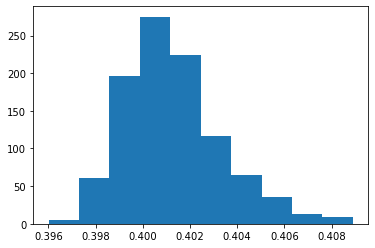

In [160]:
full_mods_NP=mods=s3_fit_1000bs_AF_NP.modUncert.samples
plt.hist(full_mods_NP)

(array([  1.,   3.,  17.,  63., 140., 250., 255., 188.,  61.,  23.]),
 array([67.0981901 , 67.82400895, 68.54982781, 69.27564667, 70.00146552,
        70.72728438, 71.45310324, 72.17892209, 72.90474095, 73.6305598 ,
        74.35637866]),
 <BarContainer object of 10 artists>)

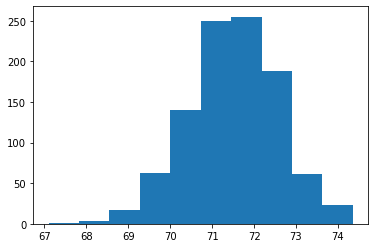

In [163]:
full_concs_NP=mods=s3_fit_1000bs_AF_NP.concUncert.samples
plt.hist(full_concs_NP)

### alpha not fixed, parallel

In [158]:
# Random samples from bootstrapping
import random

# Variables from bootstrapping
V_BS = s3_fit_1000bs_ANF_P[0]
P_BS = s3_fit_1000bs_ANF_P[1]
mods_BS = s3_fit_1000bs_ANF_P[3]
concs_BS=s3_fit_1000bs_ANF_P[4]
regparam_BS=s3_fit_1000bs_ANF_P[5]

nDraws=100
idxSamples = random.sample(range(V_BS.samples.shape[0]), nDraws)


# Extract fitted dipolar signal
Vfit = V_BS.mean
Vs = V_BS.samples[idxSamples]

# Extract fitted distance distribution
Pfit = P_BS.mean
Ps = P_BS.samples[idxSamples]

# Extract the unmodulated contribution
P_scale = s3_fit_1000bs_ANF_P[2].mean
Bfcn = lambda mod,conc: P_scale*(1-mod)*dl.bg_hom3d(t3,conc,mod)
mods=mods_BS.samples[idxSamples]
concs=concs_BS.samples[idxSamples]
Bfit = Bfcn(mods_BS.mean,concs_BS.mean)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs.append(Bfcn(mod,conc))

(0.0, 0.869885899849443)

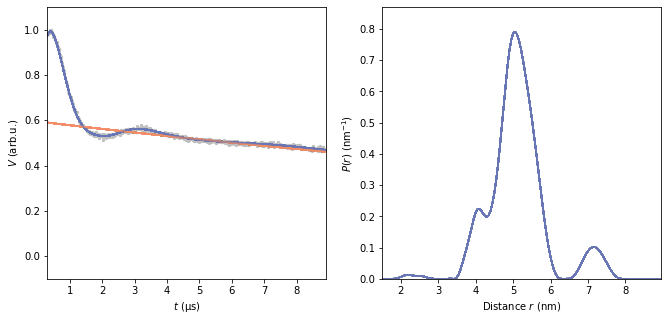

In [154]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(11)
orange = '#F38D68'

# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    ax1.plot(t3,V,color='#6876B6',alpha=0.2)
    ax1.plot(t3,B,color=orange,alpha=0.2)
ax1.scatter(t3, V3exp, color='#BFBFBF', s=5)
#ax1.plot(t1,Vfit,color=violet,label='Fit')
#ax1.plot(t1,Bfit,'--',color=orange,label='Unmodulated contribution')
ax1.set_xlabel('$t$ (µs)')
ax1.set_ylabel('$V$ (arb.u.)')
ax1.set_xlim((min(t3), max(t3)))
ax1.set_ylim(-0.1,1.1)

# Plot the distance distribution
for P in Ps:
    ax2.plot(r3,P,color='#6876B6',alpha=0.2)
#ax2.plot(r1,Pfit,color=violet,label='Fit')
ax2.set_xlabel('Distance $r$ (nm)')
ax2.set_ylabel('$P(r)$ (nm$^{-1}$)')
Pmax = max([max(P) for P in Ps])
ax2.set_xlim(min(r3), max(r3))
ax2.set_ylim(0, Pmax*1.1)

#### Checking output histograms

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1000.]),
 array([0.40099065, 0.40104728, 0.40110392, 0.40116056, 0.40121719,
        0.40127383, 0.40133047, 0.4013871 , 0.40144374, 0.40150038,
        0.40155702]),
 <BarContainer object of 10 artists>)

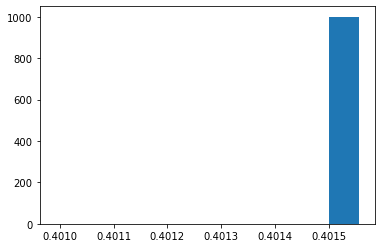

In [161]:
full_mods_P = s3_fit_1000bs_ANF_P[3].samples
plt.hist(full_mods_P)

(array([1000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           1.]),
 array([71.33455553, 71.37402588, 71.41349623, 71.45296658, 71.49243693,
        71.53190728, 71.57137763, 71.61084798, 71.65031833, 71.68978868,
        71.72925903]),
 <BarContainer object of 10 artists>)

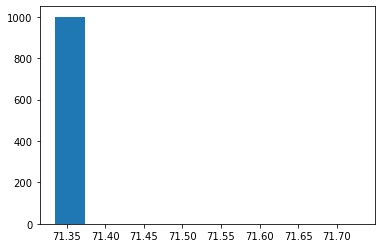

In [162]:
full_concs_P = s3_fit_1000bs_ANF_P[4].samples
plt.hist(full_concs_P)

## For paper

In [20]:
s3_fit_500bs_ANF_NP=dl.read_pickle('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/Figure6/s3_fit_500bs_alphafixed_notparallel.pkl')

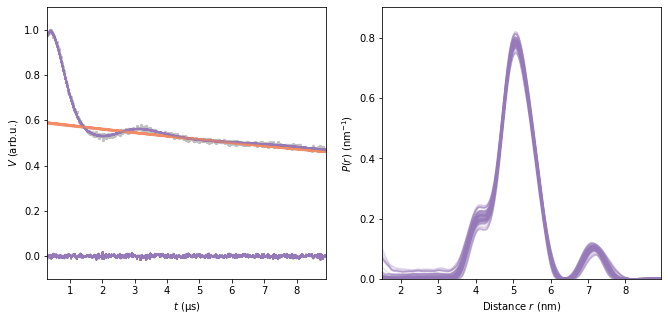

In [22]:
# Random samples from bootstrapping
import random
nDraws=100
idxSamples = random.sample(range(s3_fit_500bs_ANF_NP.modelUncert.samples.shape[0]), nDraws)

# Extract fitted dipolar signal
Vfit = s3_fit_500bs_ANF_NP.model
Vs = s3_fit_500bs_ANF_NP.modelUncert.samples[idxSamples]

# Extract fitted distance distribution
Pfit = s3_fit_500bs_ANF_NP.P
Ps = s3_fit_500bs_ANF_NP.PUncert.samples[idxSamples]

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: s3_fit_500bs_ANF_NP.P_scale*(1-mod)*dl.bg_hom3d(t3,conc,mod)
mods=s3_fit_500bs_ANF_NP.modUncert.samples[idxSamples]
concs=s3_fit_500bs_ANF_NP.concUncert.samples[idxSamples]
Bfit = Bfcn(s3_fit_500bs_ANF_NP.mod,s3_fit_500bs_ANF_NP.conc)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs.append(Bfcn(mod,conc))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(11)
orange = '#F38D68'

# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    residuals = V - V3exp
    ax1.plot(t3,V,color='#9679B9',alpha=0.2)
    ax1.plot(t3,B,color=orange,alpha=0.2)
    ax1.plot(t3, residuals, color='#9679B9', alpha=0.2)
ax1.scatter(t3, V3exp, color='#BFBFBF', s=5)
#ax1.plot(t1,Vfit,color=violet,label='Fit')
#ax1.plot(t1,Bfit,'--',color=orange,label='Unmodulated contribution')
ax1.set_xlabel('$t$ (µs)')
ax1.set_ylabel('$V$ (arb.u.)')
ax1.set_xlim((min(t3), max(t3)))
ax1.set_ylim(-0.1,1.1)

# Plot the distance distribution
for P in Ps:
    ax2.plot(r3,P,color='#9679B9',alpha=0.2)
#ax2.plot(r1,Pfit,color=violet,label='Fit')
ax2.set_xlabel('Distance $r$ (nm)')
ax2.set_ylabel('$P(r)$ (nm$^{-1}$)')
Pmax = max([max(P) for P in Ps])
ax2.set_xlim(min(r3), max(r3))
ax2.set_ylim(0, Pmax*1.1)
plt.gcf()
fig.savefig("s3_DL_BS_500s.svg")

In [27]:
print(np.log10(s3_fit_500bs_ANF_NP.regparam))

-0.4153946452608676


# Sample 4 analysis

## Load data

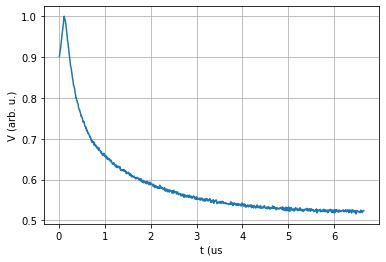

In [45]:
[V4_, t4_] = preprocess('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/ringtest_labB/sample4_labB.DSC')

# Cut off first point, shift zero time 
t4=t4_[1:]
V4exp=V4_[1:]
t4=t4+0.008
#t4 = t4-(0.12-0.008)

# Cut off 2+1 artifact
cut = 1.2
V4exp = V4exp[t4<=max(t4)-cut]
t4 = t4[t4<=max(t4)-cut]

# Normalize
V4exp = V4exp/np.max(V4exp)

# Plot
plt.plot(t4,V4exp)
plt.xlabel('t (us')
plt.ylabel('V (arb. u.)')
plt.grid()

## Build model

In [46]:
# Experimental parameters
tau1 = 0.4      # First inter-pulse delay, μs
tau2 = 8.0      # Second inter-pulse delay, μs
deadtime = 0.28  # Acquisition deadtime, μs
t4 = t4 + deadtime             # Account for deadtime

# Distance vector
r4 = np.arange(1.5,8.5,0.05) # nm

# Construct the model
V4model = dl.dipolarmodel(t4, r4, experiment = dl.ex_4pdeer(tau1,tau2, pathways=[1]))
compactness = dl.dipolarpenalty(Pmodel=None, r=r4, type='compactness')

## Fit

In [43]:
# Fit the model to the data
results_s4 = dl.fit(V4model,V4exp,penalties=compactness)

# Print results summary
print(results_s4)

Goodness-of-fit: 
========= ============= ============ ======= =========== 
 Dataset   Noise level   Reduced 𝛘2   RMSD       AIC     
========= ============= ============ ======= =========== 
   #1         0.002        0.921      0.002   -4664.125  
========= ============= ============ ======= =========== 
Model hyperparameters: 
========================== =================== 
 Regularization parameter   Penalty weight #1  
========================== =================== 
          0.058                   0.011        
========================== =================== 
Model parameters: 
=========== ==================== ========================= ====== ====================================== 
 Parameter   Value                95%-Confidence interval   Unit   Description                           
=========== ==================== ========================= ====== ====================================== 
 mod         0.373                (0.371,0.376)                    Modulation depth        

## Plot

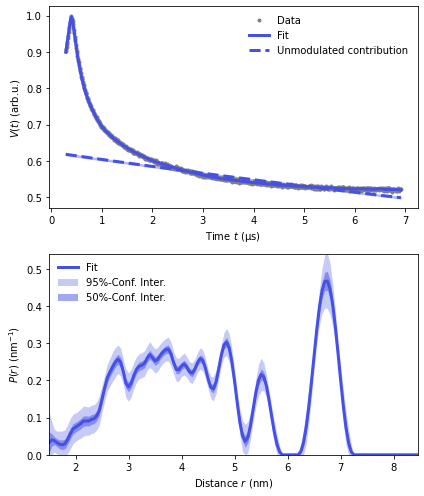

In [44]:
# Extract fitted dipolar signal
Vfit = results_s4.model
Vci = results_s4.modelUncert.ci(95)

# Extract fitted distance distribution
Pfit = results_s4.P
Pci95 = results_s4.PUncert.ci(95)
Pci50 = results_s4.PUncert.ci(50)

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: results_s4.P_scale*(1-mod)*dl.bg_hom3d(t4,conc,mod)
Bfit = Bfcn(results_s4.mod,results_s4.conc)
Bci = results_s4.propagate(Bfcn).ci(95)

plt.figure(figsize=[6,7])
violet = '#4550e6'
plt.subplot(211)
# Plot experimental and fitted data
plt.plot(t4,V4exp,'.',color='grey',label='Data')
plt.plot(t4,Vfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(t4,Vci[:,0],Vci[:,1],color=violet,alpha=0.3)
plt.plot(t4,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
plt.fill_between(t4,Bci[:,0],Bci[:,1],color=violet,alpha=0.3)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')
# Plot the distance distribution
plt.subplot(212)
plt.plot(r4,Pfit,color=violet,linewidth=3,label='Fit')
plt.fill_between(r4,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r4,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()

## Bootstrap analysis

In [47]:
s4_fit_1000bs=dl.read_pickle('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/Figure5/s4_fit_1000bs_bootuq.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/Figure5/s4_fit_1000bs_bootuq.pkl'

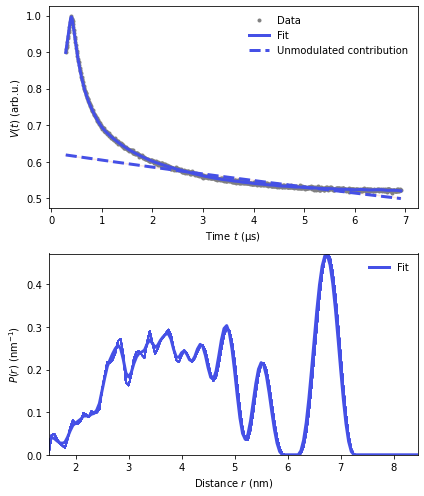

In [67]:
# Random samples from bootstrapping
import random
nDraws=100
idxSamples = random.sample(range(s4_fit_1000bs[0].samples.shape[0]), nDraws)
V_BS = s4_fit_1000bs[0]
P_BS = s4_fit_1000bs[1]
mods_BS = s4_fit_1000bs[3]
concs_BS=s4_fit_1000bs[4]

# Extract fitted dipolar signal
#Vfit = s4_fit_1000bs.model
Vfit = results_s4.model
#Vci = s1_fit_1000bs.modelUncert.ci(95)
Vs = V_BS.samples[idxSamples]

# Extract fitted distance distribution
Pfit = results_s4.P
Ps = P_BS.samples[idxSamples]

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: results_s4.P_scale*(1-mod)*dl.bg_hom3d(t4,conc,mod)
mods=mods_BS.samples[idxSamples]
concs=concs_BS.samples[idxSamples]
Bfit = Bfcn(results_s4.mod,results_s4.conc)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs_ = Bfcn(mod,conc)
Bs.append(Bs_)

plt.figure(figsize=[6,7])
violet = '#4550e6'
orange = "#F38D68"
plt.subplot(211)
# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    plt.plot(t4,V,color=violet,alpha=0.2)
    plt.plot(t4,B,color=orange,alpha=0.2)
plt.plot(t4,V4exp,'.',color='grey',label='Data')
plt.plot(t4,Vfit,linewidth=3,color=violet,label='Fit')
plt.plot(t4,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')
# Plot the distance distribution
plt.subplot(212)
for P in Ps:
    plt.plot(r4,P,color=violet,alpha=0.2)
plt.plot(r4,Pfit,color=violet,linewidth=3,label='Fit')
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()

In [ ]:
# Extract fitted dipolar signal
Vfit = s4_fit_1000bs.model
Vci = s4_fit_1000bs.modelUncert.ci(95)

# Extract fitted distance distribution
Pfit = s4_fit_1000bs.P
Pci95 = s4_fit_1000bs.PUncert.ci(95)
Pci50 = s4_fit_1000bs.PUncert.ci(50)

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: s4_fit_1000bs.P_scale*(1-mod)*dl.bg_hom3d(t4,conc,mod)
Bfit = Bfcn(s4_fit_1000bs.mod,s4_fit_1000bs.conc)
Bci = s4_fit_1000bs.propagate(Bfcn).ci(95)

plt.figure(figsize=[6,7])
violet = '#4550e6'
plt.subplot(211)
# Plot experimental and fitted data
plt.plot(t4,V4exp,'.',color='grey',label='Data')
plt.plot(t4,Vfit,linewidth=3,color=violet,label='Fit')
plt.fill_between(t4,Vci[:,0],Vci[:,1],color=violet,alpha=0.3)
plt.plot(t4,Bfit,'--',linewidth=3,color=violet,label='Unmodulated contribution')
plt.fill_between(t4,Bci[:,0],Bci[:,1],color=violet,alpha=0.3)
plt.legend(frameon=False,loc='best')
plt.xlabel('Time $t$ (μs)')
plt.ylabel('$V(t)$ (arb.u.)')
# Plot the distance distribution
plt.subplot(212)
plt.plot(r4,Pfit,color=violet,linewidth=3,label='Fit')
plt.fill_between(r4,Pci95[:,0],Pci95[:,1],alpha=0.3,color=violet,label='95%-Conf. Inter.',linewidth=0)
plt.fill_between(r4,Pci50[:,0],Pci50[:,1],alpha=0.5,color=violet,label='50%-Conf. Inter.',linewidth=0)
plt.legend(frameon=False,loc='best')
plt.autoscale(enable=True, axis='both', tight=True)
plt.xlabel('Distance $r$ (nm)')
plt.ylabel('$P(r)$ (nm$^{-1}$)')
plt.tight_layout()
plt.show()

## For paper

In [48]:
s4_fit_500bs_ANF_NP=dl.read_pickle('/Users/sarahsweger/SynologyDrive/SynologyDrive/Bayesian/Nonparametric/Paper/Figure6/s4_fit_500bs_alphafixed_notparallel.pkl')

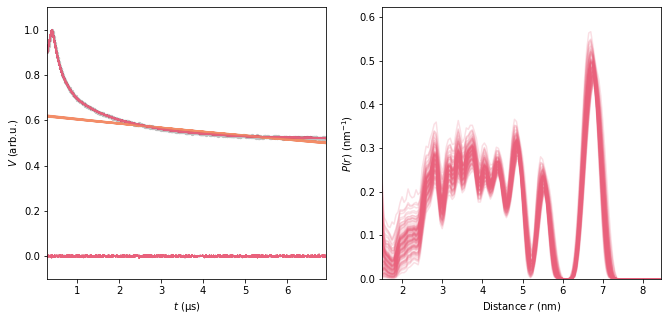

In [49]:
# Random samples from bootstrapping
import random
nDraws=100
idxSamples = random.sample(range(s4_fit_500bs_ANF_NP.modelUncert.samples.shape[0]), nDraws)

# Extract fitted dipolar signal
Vfit = s4_fit_500bs_ANF_NP.model
Vs = s4_fit_500bs_ANF_NP.modelUncert.samples[idxSamples]

# Extract fitted distance distribution
Pfit = s4_fit_500bs_ANF_NP.P
Ps = s4_fit_500bs_ANF_NP.PUncert.samples[idxSamples]

# Extract the unmodulated contribution
Bfcn = lambda mod,conc: s4_fit_500bs_ANF_NP.P_scale*(1-mod)*dl.bg_hom3d(t4,conc,mod)
mods=s4_fit_500bs_ANF_NP.modUncert.samples[idxSamples]
concs=s4_fit_500bs_ANF_NP.concUncert.samples[idxSamples]
Bfit = Bfcn(s4_fit_500bs_ANF_NP.mod,s4_fit_500bs_ANF_NP.conc)
Bs=[]
for mod, conc in zip(mods,concs):
    Bs.append(Bfcn(mod,conc))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(11)
orange = '#F38D68'

# Plot experimental and fitted data
for V,B in zip(Vs,Bs):
    residuals = V - V4exp
    ax1.plot(t4,V,color='#E9617C',alpha=0.2)
    ax1.plot(t4,B,color=orange,alpha=0.2)
    ax1.plot(t4, residuals, color='#E9617C', alpha=0.2)
ax1.scatter(t4, V4exp, color='#BFBFBF', s=5)
#ax1.plot(t1,Vfit,color=violet,label='Fit')
#ax1.plot(t1,Bfit,'--',color=orange,label='Unmodulated contribution')
ax1.set_xlabel('$t$ (µs)')
ax1.set_ylabel('$V$ (arb.u.)')
ax1.set_xlim((min(t4), max(t4)))
ax1.set_ylim(-0.1,1.1)

# Plot the distance distribution
for P in Ps:
    ax2.plot(r4,P,color='#E9617C',alpha=0.2)
#ax2.plot(r1,Pfit,color=violet,label='Fit')
ax2.set_xlabel('Distance $r$ (nm)')
ax2.set_ylabel('$P(r)$ (nm$^{-1}$)')
Pmax = max([max(P) for P in Ps])
ax2.set_xlim(min(r4), max(r4))
ax2.set_ylim(0, Pmax*1.1)
plt.gcf()
fig.savefig("s4_DL_BS_500s.svg")

In [50]:
print(np.log10(s4_fit_500bs_ANF_NP.regparam))

-1.6862855953434732
